### Notebook from : https://www.kaggle.com/code/jiaowoguanren/sars-cov-2-ct-scan-dataset-classification-tf-0-99

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%pip install split-folders

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import pathlib, splitfolders
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

# USE OF SARSCOV2-CTSCAN-DATASET

In [ ]:
epochs = 30
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

def create_data_binary(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='../sarscov2-ctscan-dataset-splitted/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(rescale=1.0 / 255)
    train_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/train/', target_size=(img_height, img_width),
                                            class_mode='binary', batch_size=batch_size, subset='training')
    val_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/val/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)

    return train_ds, val_ds


train_data, val_data = create_data_binary('../sarscov2-ctscan-dataset/')

# USE OF COVID-CT-master DATASET

In [ ]:
epochs = 30
batch_size = 32
img_height, img_width = 150, 150
input_shape = (img_height, img_width, 3)

data_gen = ImageDataGenerator(rescale=1.0 / 255)

"""
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
"""
                                  
train_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/train/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          subset='training')
                                         
test_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/test/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary')

val_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/val/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          shuffle=False)

### Base Model CNN

In [ ]:
class BaseModel(tf.keras.Model):
    def __init__(self):
        super(BaseModel, self).__init__()

        self.C1 = Conv2D(32, (3 * 3), padding='same', input_shape = input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(2, padding='same')
        
        self.C2 = Conv2D(32, (3 * 3), padding='same')
        self.B2 = BatchNormalization()
        self.A2 = Activation('relu')
        self.P2 = MaxPooling2D(2, padding='same')
        self.Dr1 = Dropout(0.3)
        
        self.C3 = Conv2D(32, (3 * 3), padding='same')
        self.B3 = BatchNormalization()
        self.A3 = Activation('relu')
        self.P3 = MaxPooling2D(2, padding='same')
        self.Dr2 = Dropout(0.3)
        
        self.F1 = Flatten()
        self.D1 = Dense(256, activation='relu')
        self.B4 = BatchNormalization()
        self.D2 = Dense(256, activation='relu')
        self.D3 = Dense(256, activation='relu')
        self.D4 = Dense(256, activation='relu')
        self.Dr3 = Dropout(0.3)
        self.D5 = Dense(1, activation='sigmoid')
        
        
    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)
        
        x = self.C2(x)
        x = self.B2(x)
        x = self.A2(x)
        x = self.P2(x)
        x = self.Dr1(x)
        
        x = self.C3(x)
        x = self.B3(x)
        x = self.A3(x)
        x = self.P3(x)
        x = self.Dr2(x)
        
        x = self.F1(x)
        x = self.D1(x)
        x = self.B4(x)
        x = self.D2(x)
        x = self.D3(x)
        x = self.D4(x)
        x = self.Dr3(x)
        y = self.D5(x)
        
        return y
    
    def __repr__(self):
        name = 'Huang_Model'
        return name
    
    
net = BaseModel()

net.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

checkpoint_save_path = './Model.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    net.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_weights_only=True,
                                                 save_best_only=True)

#history = net.fit(train_data, epochs=30, batch_size=batch_size, callbacks=[cp_callback])
history = net.fit(train_data, epochs=30, batch_size=batch_size)

net.summary()

file = open('./weights.txt', 'w')
for v in net.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()

### VGG16 CNN

In [ ]:
disease_types = ['COVID', 'non-COVID']

data_dir = '../sarscov2-ctscan-dataset-splitted/'

# resize images from data_dir train, test and val and create new dataset resized
def resize_images(data_dir):
    # resize images from data_dir train, test and val and create new dataset resized
    for folder in ['train', 'test', 'val']:
        for file in os.listdir(os.path.join(data_dir, folder)):
            if file.endswith('.jpg'):

                img = cv2.imread(os.path.join(data_dir, folder, file))
                img = cv2.resize(img, (224, 224))
                cv2.imwrite(os.path.join(data_dir, 'resized', folder, file), img)

# resize_images(data_dir)

# create data generator for train, test and val
def create_data_binary(data_dir):
    data_dir = pathlib.Path(data_dir)
    # create data generator for train, test and val
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, 'train'),
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(224, 224),
        batch_size=32,
        label_mode='binary')
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, 'test'),
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(224, 224),
        batch_size=32,
        label_mode='binary')
    return train_ds, test_ds

train_ds, test_ds = create_data_binary('../sarscov2-ctscan-dataset-splitted/')


In [ ]:
class VGG16Model(tf.keras.Model):
    def __init__(self):
        super(VGG16Model, self).__init__()
        
        self.C1 = Conv2D(32, (3 * 3), padding='same', input_shape = input_shape)

        #self.VGG = VGG16(weights='imagenet', include_top = False, input_shape= input_shape)
        self.VGG = VGG16(weights='imagenet', include_top = False)

        self.GAP = GlobalAveragePooling2D()
        self.B1 = BatchNormalization()

        self.D1 = Dense(32, activation='relu')
        self.B2 = BatchNormalization()
        
        self.D2 = Dense(32, activation='softmax')
    
    def call(self, x):
        x = self.C1(x)
        x = self.VGG(x)
        x = self.GAP(x)
        x = self.B1(x)
        x = self.D1(x)
        x = self.B2(x)
        y = self.D2(x)
        
        return y

    def __repr__(self):
        name = 'VGG16Model'
        return name
        
net = VGG16Model()

optimizer = Adam(learning_rate= 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
net.compile(loss = 'categorical_crossentropy', optimizer =optimizer, metrics = ['accuracy'])

annealer = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)

# Fits the model on batches with real-time data augmentation
#history = net.fit(X_Train, epochs=epochs, batch_size = batch_size, callbacks = [annealer])
history = net.fit(train_ds, epochs=epochs, batch_size = batch_size)

model.summary()

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

### Complete new structure VGG16

In [67]:
disease_types = ['COVID', 'non-COVID']

train_dir = data_dir = '../sarscov2-ctscan-dataset'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train

,File,ID,Disease Type
0,COVID/Covid (640).png,0,COVID
1,COVID/Covid (210).png,0,COVID
2,COVID/Covid (705).png,0,COVID
3,COVID/Covid (355).png,0,COVID
4,COVID/Covid (586).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (1052).png,1,non-COVID
2477,non-COVID/Non-Covid (51).png,1,non-COVID
2478,non-COVID/Non-Covid (1117).png,1,non-COVID
2479,non-COVID/Non-Covid (671).png,1,non-COVID


Text(0.5, 1.0, 'Frequency Histogram of Disease IDs')

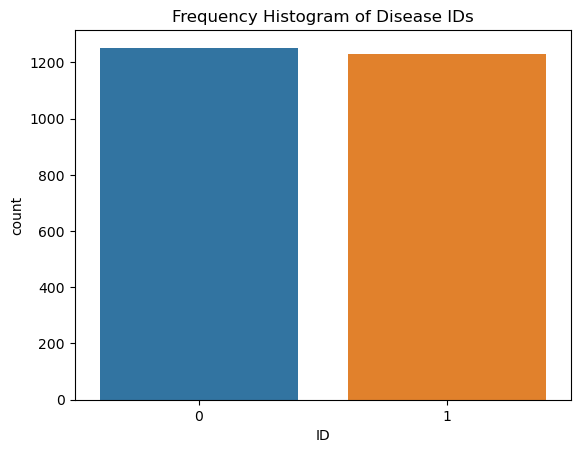

In [68]:
Seed = 7
IMAGE_SIZE = 224
train = train.sample(frac = 1, replace=False, random_state = Seed) 
train = train.reset_index(drop = True) # Reset indices (row numbers)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram of Disease IDs")

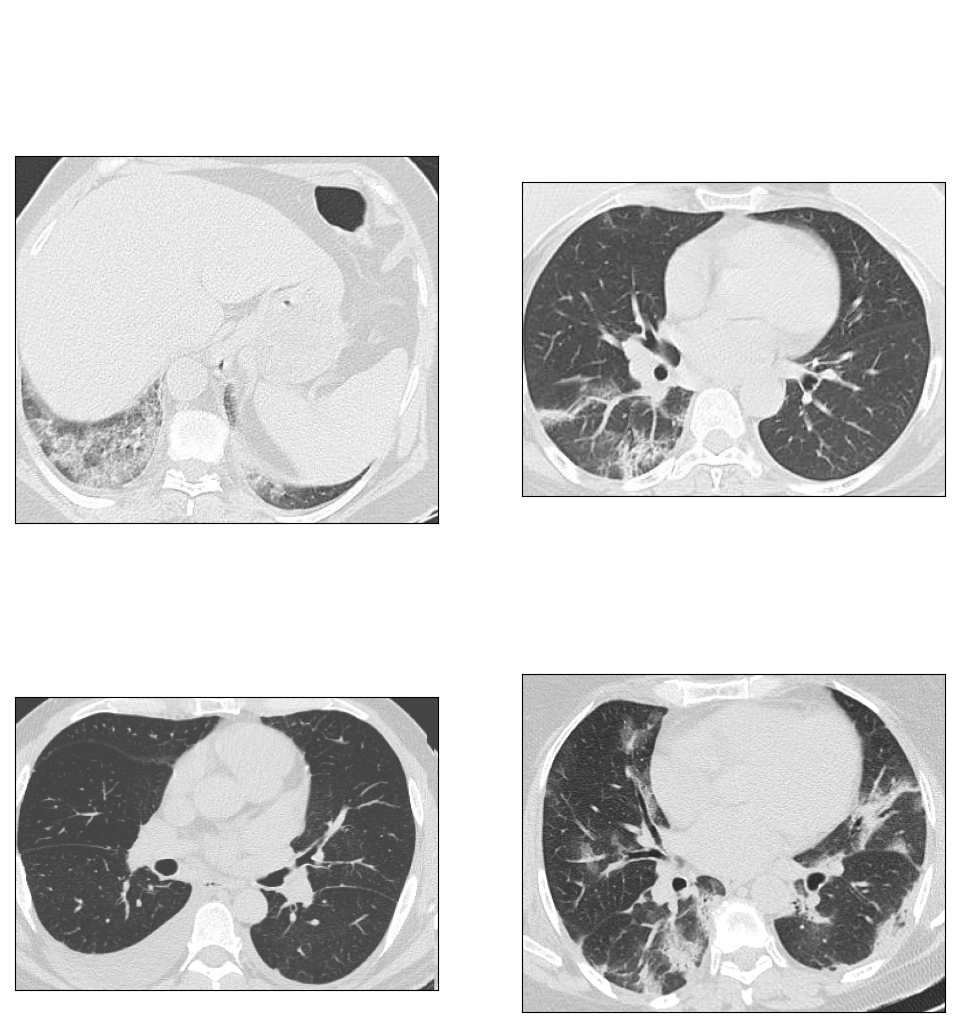

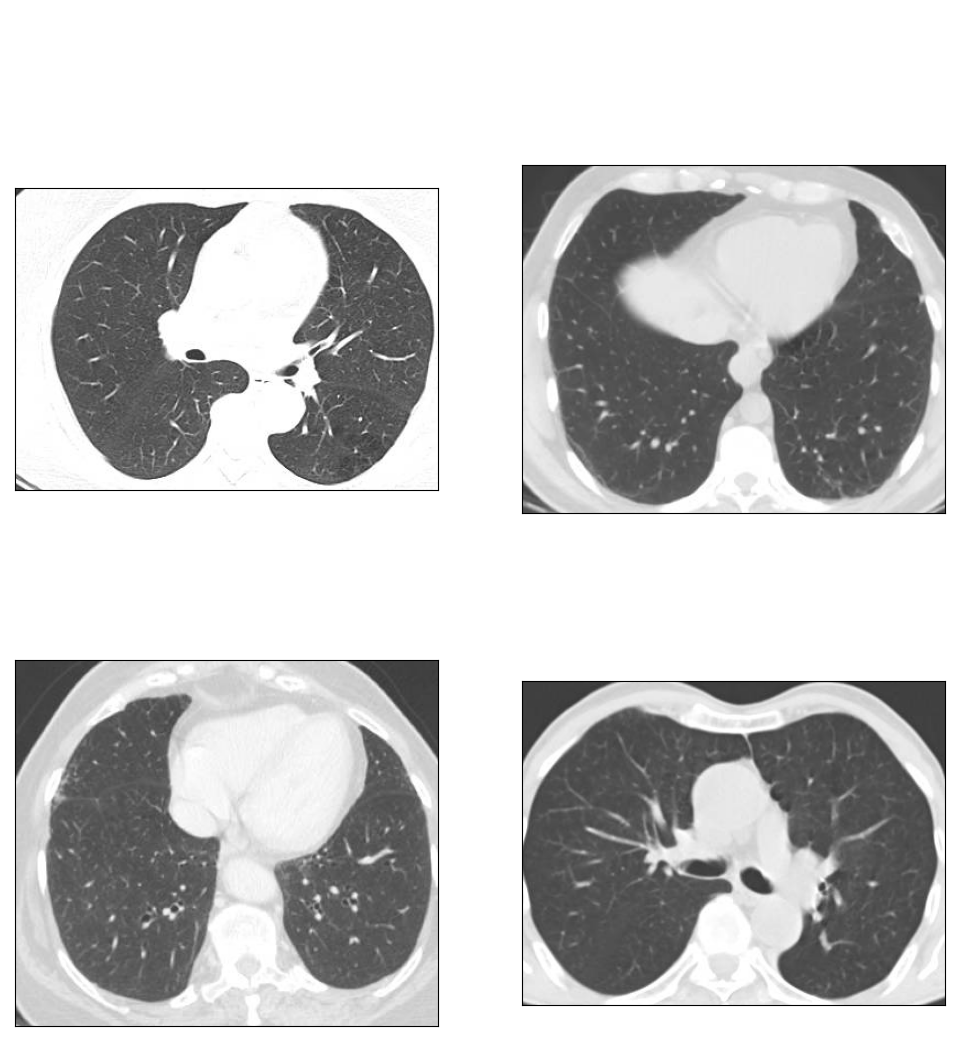

In [69]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
            
# Displays first n images of class from training set
plot_defects('COVID', 2, 2)
plot_defects('non-COVID', 2, 2)

In [70]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [71]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

# Normalize the data
X_Train = X_train / 255.0
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

Train Shape: (2481, 224, 224, 3)


In [72]:
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2,
                                                  random_state = Seed)

print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1984, 224, 224, 3)
X_val: (497, 224, 224, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


In [73]:
def build_vgg(IMAGE_SIZE, channels):
    
    VGG = VGG16(weights='imagenet', include_top = False)
    
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = VGG(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    output = Dense(2,activation = 'softmax')(x)
 

    # model
    model = Model(input,output)
   
    
    optimizer = Adam(learning_rate= 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy', optimizer =optimizer, metrics = ['accuracy'])
    model.summary()
    
    return model

In [74]:
channels = 3

model = build_vgg(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2, # Range for random horizontal shifts
                        height_shift_range = 0.2, # Range for random vertical shifts
                        zoom_range = 0.2, # Range for random zoom
                        horizontal_flip = True, # Randomly flip inputs horizontally
                        vertical_flip = True) # Randomly flip inputs vertically

datagen.fit(X_train)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 3)       84        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_10  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_20 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 32)                1641

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [79]:
BATCH_SIZE = 32
EPOCHS = 65


# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer],
               validation_data = (X_val, Y_val))

Epoch 1/65
62/62 [==============================] - 171s 3s/step - loss: 0.3612 - accuracy: 0.8508 - val_loss: 2.6783 - val_accuracy: 0.5332 - lr: 0.0030
Epoch 2/65
62/62 [==============================] - 193s 3s/step - loss: 0.3652 - accuracy: 0.8422 - val_loss: 3.4452 - val_accuracy: 0.4970 - lr: 0.0030
Epoch 3/65
62/62 [==============================] - 205s 3s/step - loss: 0.3563 - accuracy: 0.8508 - val_loss: 5.8589 - val_accuracy: 0.5372 - lr: 0.0030
Epoch 4/65
62/62 [==============================] - 213s 3s/step - loss: 0.3462 - accuracy: 0.8604 - val_loss: 7.4464 - val_accuracy: 0.4628 - lr: 0.0030
Epoch 5/65
62/62 [==============================] - 212s 3s/step - loss: 0.3506 - accuracy: 0.8528 - val_loss: 0.3300 - val_accuracy: 0.8491 - lr: 0.0030
Epoch 6/65
62/62 [==============================] - 209s 3s/step - loss: 0.3340 - accuracy: 0.8548 - val_loss: 1.5267 - val_accuracy: 0.5231 - lr: 0.0030
Epoch 7/65
62/62 [==============================] - 212s 3s/step - loss: 0.3

KeyboardInterrupt: 

In [76]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 9s 570ms/step - loss: 1.4247 - accuracy: 0.4889
Final Loss: 1.4247031211853027, Final Accuracy: 0.48893365263938904


2023-03-13 13:57:02.914687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 9s 577ms/step


Text(0.5, 192.72222222222217, 'Predicted')

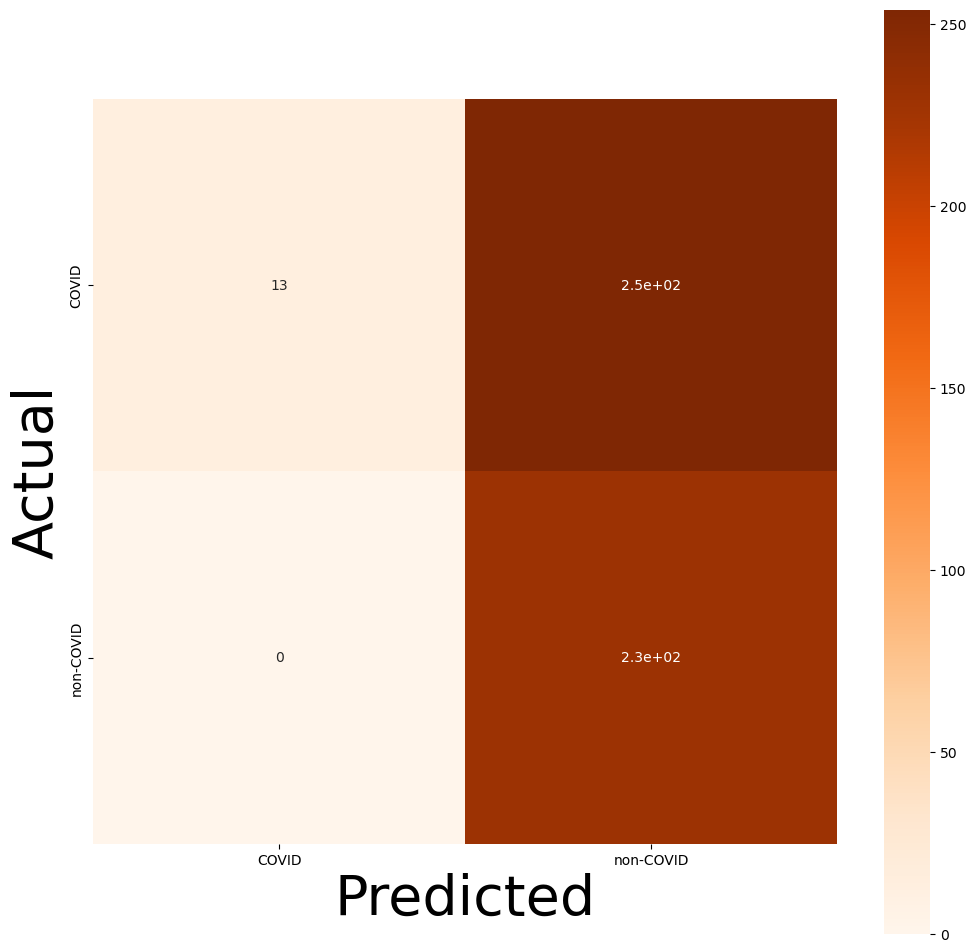

In [77]:
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Oranges, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

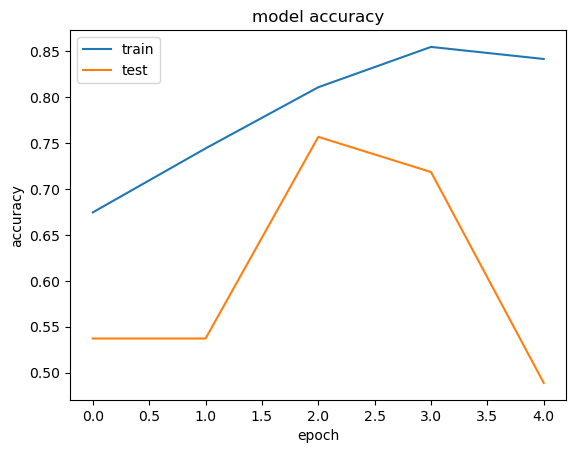

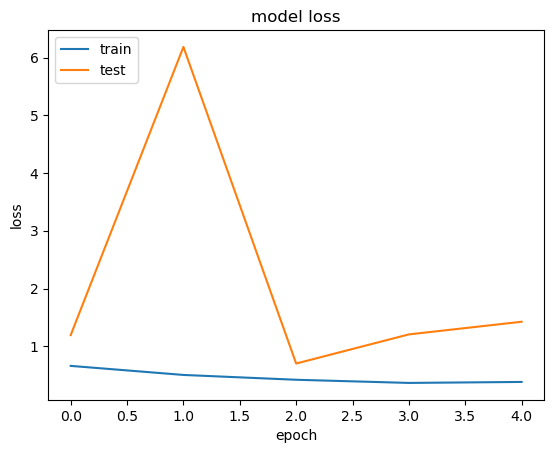

In [78]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()